
---
# **License Plate Detection**
##**David Peterson - ECE 4424 - Spring 2022 Project - AMLPR**
---

### **Data Loading and Pre-Processing**###
1.   Mount Google Drive
2.   Load original license plate image dataset - location labels
3.   Modify original license plate image dataset structure for YOLOv3 integration

**Dataset Modification Details:**  

- Dataset Train-Test Split: 80% Train | 20% Train

- File Structure in Detection Directory:
> lp_loc_img_data (original)   
> detection_data (modified)  
> darknet   
> classes.names  
> darknet-yolov3-custom.cfg  
> train.log  
> yolov3.data  

- Original format of dataset:  
  - Separate train and test text files with image file paths and labels for each image
> images/imageX.jpg  
> imageX label   
> ...

- Modified format of dataset:   
  - Separate train and test text files with only image file paths  
  - Separate labels directory with text files for individual image labels

  - Modify Label Format
    - Current Label Format:  
  > Top-Left X | Top-Left Y | Bottom-Right X | Bottom-Right Y 

    - Normalized Label Format:
  > Class ID | Center-X | Center-Y | Width | Height

  - File Structure in detection_data directory:
> detection_train.txt  
> detection_test.txt  
> images  
> weights  
> labels  



In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# append the directory to your python path using sys
import sys
import os
prefix = '/content/drive/MyDrive/'

# customized path to detection directory
cust_path_detection = 'ECE4424/Project/detection'
sys_path = prefix + cust_path_detection
sys.path.append(sys_path)

print("Path to detection directory: {}".format(sys_path))

Path to detection directory: /content/drive/MyDrive/ECE4424/Project/detection


In [ ]:
# initialize path constants
LP_LOC_IMG_DATA_DIR_PATH = sys_path + "/lp_loc_img_data"              # path to original dataset directory
TRAIN_DATA_FILE_PATH = LP_LOC_IMG_DATA_DIR_PATH + "/train_data.txt"   # path to train data file
TEST_DATA_FILE_PATH = LP_LOC_IMG_DATA_DIR_PATH + "/test_data.txt"     # path to test data file

# load train and test datasets
train_data_file = open(TRAIN_DATA_FILE_PATH, "r")  # open train data file
test_data_file = open(TEST_DATA_FILE_PATH, "r")    # open test data file

# separate train data into file names and labels lists
train_data_fps = []                                                         # initialize list for train data image file paths
train_data_lbls = []                                                        # initialize list for train data labels
for idx, line in enumerate(train_data_file):                                # for each line in the train data file
    if not idx % 2:                                                             # if line index is even
        train_data_fps.append(line.strip()[1:])                                     # append image file name to train data image file names list
    else:                                                                       # else
        train_data_lbls.append(tuple(map(int, line.strip().split(","))))            # append label to train data label list as a tuple of integers

# organize train data into file names:labels dictionary
train_data = {}                                                             # initialize dictionary to store names:labels key:value pairs
for idx in range(len(train_data_fps)):                                      # for each train image
    train_data[train_data_fps[idx]] = train_data_lbls[idx]                      # insert file name-labels key-value pair

# separate test data into file names and labels lists
test_data_fps = []                                                          # initialize list for test data image file paths
test_data_lbls = []                                                         # initialize list for test data labels
for idx, line in enumerate(test_data_file):                                 # for each line in the test data file
    if not idx % 2:                                                             # if line index is even
        test_data_fps.append(line.strip()[1:])                                      # append image file name to test data image file names list
    else:                                                                       # else
        test_data_lbls.append(tuple(map(int, line.strip().split(","))))             # append label to test data label list as a tuple of integers

# organize test data into file names:labels dictionary
test_data = {}                                                              # initialize dictionary to store names:labels key:value pairs
for idx in range(len(test_data_fps)):                                       # for each test image
    test_data[test_data_fps[idx]] = test_data_lbls[idx]                         # insert file name-labels key-value pair

print("Train Data: {}".format(train_data))
print("Amount of Train Data: {}".format(len(train_data)))
print("Test Data: {}".format(test_data))
print("Amount of Test Data: {}".format(len(test_data)))
print("[STATUS] Original data loaded successfully.")

Train Data: {'/images/cars4_052.jpg': (202, 247, 270, 270), '/images/cars2_021.jpg': (292, 249, 375, 276), '/images/cars4_074.jpg': (156, 253, 224, 281), '/images/cars4_010.jpg': (280, 269, 348, 295), '/images/cars3_026.jpg': (297, 217, 358, 242), '/images/cars4_085.jpg': (273, 231, 343, 258), '/images/cars063.jpg': (323, 240, 400, 263), '/images/cars4_061.jpg': (238, 218, 324, 246), '/images/cars4_080.jpg': (400, 248, 475, 275), '/images/cars4_128.jpg': (257, 242, 329, 266), '/images/cars4_127.jpg': (260, 219, 334, 247), '/images/cars4_065.jpg': (296, 247, 383, 281), '/images/cars4_037.jpg': (431, 355, 504, 382), '/images/cars060.jpg': (326, 292, 395, 315), '/images/cars4_105.jpg': (409, 96, 497, 129), '/images/cars4_116.jpg': (253, 270, 308, 286), '/images/cars4_124.jpg': (289, 258, 368, 289), '/images/cars2_052.jpg': (379, 207, 459, 232), '/images/cars4_060.jpg': (250, 229, 334, 257), '/images/cars4_005.jpg': (270, 233, 361, 260), '/images/cars056.jpg': (214, 207, 290, 228), '/image

In [ ]:
# initialize path constants
DETECTION_DATA_DIR_PATH = sys_path + "/detection_data"  # path to modified dataset directory

# create detection_train.txt - contains paths for images in train data
detection_train_file = open(DETECTION_DATA_DIR_PATH + "/detection_train.txt", "w+")  # open detection_train.txt in write mode - create if does not exist
for fp in train_data.keys():                                                         # for each file path in train data
    detection_train_file.write(DETECTION_DATA_DIR_PATH + fp + "\n")                     # write the file path to detection_train.txt on a new line
detection_train_file.close()                                                         # close detection_train.txt

print("[STATUS] detection_train.txt created successfully.")

# create detection_test.txt - contains paths for images in test data
detection_test_file = open(DETECTION_DATA_DIR_PATH + "/detection_test.txt", "w+")  # open detection_test.txt in write mode - create if does not exist
for fp in test_data.keys():                                                        # for each file path in test data
    detection_test_file.write(DETECTION_DATA_DIR_PATH + fp + "\n")                    # write the file path to detection_test.txt on a new line
detection_test_file.close()                                                        # close detection_test.txt

print("[STATUS] detection_test.txt created successfully.")

[STATUS] detection_train.txt created successfully.
[STATUS] detection_test.txt created successfully.


In [ ]:
# install python imaging library - Pillow
!pip install Pillow

In [ ]:
# import Pillow - access image size
from PIL import Image

# function to normalize center coordinates (x, y), width, and height of the 
# ground-truth bounding box (gtbb) using the width and height of the given image
# param img - path to image
# param tlx - gtbb top-left x-coordinate
# param tly - gtbb top-left y-coordinate
# param brx - gtbb bottom-right x-coordinate
# param bry - gtbb bottom-right y-coordinate
def normalize(img, tlx, tly, brx, bry):
    curr_img = Image.open(DETECTION_DATA_DIR_PATH + img)   # open current image using Pillow library
    curr_img_w, curr_img_h = curr_img.size                 # access current image size

    gtbb_cx = (tlx + brx) / 2                              # gtbb center-x
    gtbb_cy = (tly + bry) / 2                              # gtbb center-y
    gtbb_w = brx - tlx                                     # gtbb width
    gtbb_h = bry - tly                                     # gtbb height

    ncx = float(gtbb_cx / curr_img_w)                      # normalize gtbb center x-coordinate
    ncy = float(gtbb_cy / curr_img_h)                      # normalize gtbb center y-coordinate 
    nw = float(gtbb_w / curr_img_w)                        # normalize gtbb width
    nh = float(gtbb_h / curr_img_h)                        # normalize gtbb height
    return ncx, ncy, nw, nh                                # return normalized center coordinates, width, and height

print("[STATUS] Normalize function compiled successfully.")

Normalize function compiled successfully.


In [ ]:
# import re (built-in) - multiple delimiters
import re

# initialize path constants
DETECTION_LABELS_DIR_PATH = DETECTION_DATA_DIR_PATH + "/labels"   # path to labels directory

# combine original train and test data image labels and file paths
all_data = {}
all_data.update(train_data)
all_data.update(test_data)

# create modified train and test data labels
for fp, label in all_data.items():                                               # for each image
    class_id = 0                                                                     # only 1 class => all labels have Class ID 0
    ncx, ncy, nw, nh = normalize(fp, label[0], label[1], label[2], label[3])         # normalize ground truth bounding box center-coordinates, width, and height labels
    fn = re.split("/|\.", fp)[2]                                                     # split image file path by '/' and '.' delimiters to obtain file name
    label_file = open(DETECTION_LABELS_DIR_PATH + "/" + fn + ".txt", "w+")           # open image label text file in write mode - create if does not exist
    label_vals = (class_id, ncx, ncy, nw, nh)                                        # create list of final label values
    for val in label_vals:                                                           # for each value in the final label
        label_file.write(str(val) + " ")                                                # write the final label values to the image label text file
    label_file.close()                                                               # close image label text file

print("[STATUS] Label files for all data created successfully.")

Label files for all data created successfully.


### **Darknet Loading and Building**###

1.   Clone Darknet (https://github.com/pjreddie/darknet)
2.   Build Darknet
3.   Modify Darknet files for custom fine-tuning and build again
4.   Convert files to Unix format

**Darknet File Modification Details:**  
- Change rate of model file saving to be more often
  - After first 1000 iterations (saving model every 100 iterations), modify to save model every 1000 iterations (changed from 10000)

- Import starting weights from a pre-trained model (https://pjreddie.com/media/files/darknet53.conv.74)
  - Fine tune model from pre-trained weights (opposed to random weights) to decrease learning time

- Set paths to relevant files for training (yolov3.data)
  - detection_train.txt
  - detection_test.txt
  - classes.names
  - weights

- Update YOLOv3 Configuration parameters
  - Batch size, learning rate annealing, steps, number of convolutional filters, etc.




In [ ]:
# ensure working directory is detection directory
# %cd /content/drive/MyDrive/ECE4424/Project/detection/

# # clone Darknet 
# !git clone https://github.com/pjreddie/darknet

# # change working directory to cloned Darknet directory in detection directory
# %cd /content/drive/MyDrive/ECE4424/Project/detection/darknet
# !ls

# # download pre-trained model
# !wget https://pjreddie.com/media/files/darknet53.conv.74 -O /content/drive/MyDrive/ECE4424/Project/detection/darknet/darknet53.conv.74

# build Darknet
%cd /content/drive/MyDrive/ECE4424/Project/detection/darknet
!make
!chmod +x ./darknet

# perform modifications to Darknet files for project usage

/content/drive/MyDrive/ECE4424/Project/detection/darknet
make: Nothing to be done for 'all'.


In [ ]:
# install unix format conversion tool - dos2unix
!sudo apt install dos2unix

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  dos2unix
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 351 kB of archives.
After this operation, 1,267 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 dos2unix amd64 7.3.4-3 [351 kB]
Fetched 351 kB in 1s (463 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package dos2unix.
(Reading database ... 155335 files and directories curren

In [ ]:
# re-format relevant files for training
!dos2unix /content/drive/MyDrive/ECE4424/Project/detection/detection_data/detection_train.txt
!dos2unix /content/drive/MyDrive/ECE4424/Project/detection/detection_data/detection_test.txt
!dos2unix /content/drive/MyDrive/ECE4424/Project/detection/classes.names
!dos2unix /content/drive/MyDrive/ECE4424/Project/detection/yolov3.data
!dos2unix /content/drive/MyDrive/ECE4424/Project/detection/darknet-yolov3-train-custom.cfg
!dos2unix /content/drive/MyDrive/ECE4424/Project/detection/darknet-yolov3-test-custom.cfg

dos2unix: converting file /content/drive/MyDrive/ECE4424/Project/detection/detection_data/detection_train.txt to Unix format...
dos2unix: converting file /content/drive/MyDrive/ECE4424/Project/detection/detection_data/detection_test.txt to Unix format...
dos2unix: converting file /content/drive/MyDrive/ECE4424/Project/detection/classes.names to Unix format...
dos2unix: converting file /content/drive/MyDrive/ECE4424/Project/detection/yolov3.data to Unix format...
dos2unix: converting file /content/drive/MyDrive/ECE4424/Project/detection/darknet-yolov3-train-custom.cfg to Unix format...
dos2unix: converting file /content/drive/MyDrive/ECE4424/Project/detection/darknet-yolov3-test-custom.cfg to Unix format...


### **YOLOv3 - Train the Model**###

1.   Ensure GPU is enabled and connected
2.   Utilize Darknet to train
3.   Analyze training loss after completion

Citation for Loss Visualization Code: https://learnopencv.com

In [ ]:
# ensure GPU runtime is connnected
!nvidia-smi

Wed Mar 16 23:08:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# train the model
# change working directory to cloned Darknet directory in detection directory
%cd /content/drive/MyDrive/ECE4424/Project/detection/darknet
!ls
!chmod +x ./darknet

!./darknet detector train \
                          /content/drive/MyDrive/ECE4424/Project/detection/yolov3.data \
                          /content/drive/MyDrive/ECE4424/Project/detection/darknet-yolov3-train-custom.cfg \
                          ./darknet53.conv.74 \
                          | tee /content/drive/MyDrive/ECE4424/Project/detection/train.log

Done! Plot saved as training_loss_plot.png


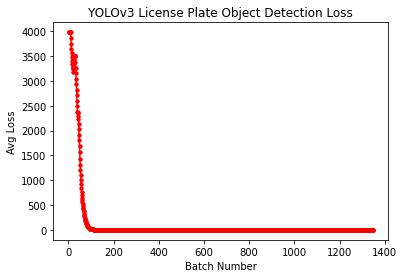

In [ ]:
# visualize training loss - image
import matplotlib.pyplot as plt

TRAIN_LOG_PATH = sys_path + "/train.log"                      # path to train log
TRAIN_LOSS_IMG_PATH = sys_path + "/training_loss_plot.png"    # path to save training loss image

lines = []
for line in open(TRAIN_LOG_PATH):
    if "avg" in line:
        lines.append(line)

iterations = []
avg_loss = []

for i in range(len(lines)):
    lineParts = lines[i].split(',')
    iterations.append(int(lineParts[0].split(':')[0]))
    avg_loss.append(float(lineParts[1].split()[0]))

fig = plt.figure()
for i in range(0, len(lines)):
    plt.plot(iterations[i:i+2], avg_loss[i:i+2], 'r.-')

plt.xlabel('Batch Number')
plt.ylabel('Avg Loss')
plt.title('YOLOv3 License Plate Object Detection Loss')
fig.savefig(TRAIN_LOSS_IMG_PATH, dpi=1000)

print("[STATUS] Plot saved as training_loss_plot.png")

In [ ]:
# visualize training loss - text
!grep "avg" /content/drive/MyDrive/ECE4424/Project/detection/train.log

### **YOLOv3 - Test the Model**###

In [ ]:
# test the model
%cd /content/drive/MyDrive/ECE4424/Project/detection/darknet
!ls
!chmod +x ./darknet

!./darknet detector test \
                         /content/drive/MyDrive/ECE4424/Project/detection/yolov3.data \
                         /content/drive/MyDrive/ECE4424/Project/detection/darknet-yolov3-test-custom.cfg \
                         /content/drive/MyDrive/ECE4424/Project/detection/detection_data/weights/darknet-yolov3-train-custom_final.weights \
                         /content/drive/MyDrive/ECE4424/Project/detection/detection_data/images/cars001.jpg

/content/drive/MyDrive/ECE4424/Project/detection/darknet
backup		   data		  LICENSE	LICENSE.mit	 python
bad.list	   examples	  LICENSE.fuck	LICENSE.v1	 README.md
cfg		   include	  LICENSE.gen	Makefile	 results
darknet		   libdarknet.a   LICENSE.gpl	obj		 scripts
darknet53.conv.74  libdarknet.so  LICENSE.meta	predictions.jpg  src
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32  0.299 BFLOPs
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32  0.177 BFLOPs
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    4 res    1                 208 x 208 x  64   ->   208 x 208 x  64
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
    7 conv    128  3 x 3 / 1